![ewatercycle logo](https://raw.githubusercontent.com/eWaterCycle/ewatercycle/main/docs/examples/logo.png)

# PCRGlobWB example use case

This example shows how the [PCRGlobWB model](https://globalhydrology.nl/research/models/pcr-globwb-2-0/) can be used within the eWaterCycle system. It is based on the example use case from https://github.com/UU-Hydro/PCR-GLOBWB_input_example.

This example use case assumes that the ewatercycle platform has been installed and configured on your system. See our [system setup documentation](https://ewatercycle.readthedocs.io/en/latest/system_setup.html) for instructions if this is not the case.

In [1]:
# This cell is only used to suppress some distracting output messages
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import matplotlib.pyplot as plt
from cartopy import crs
from cartopy import feature as cfeature
#from rich import print
import pandas as pd
import xarray as xr

import ewatercycle.forcing
import ewatercycle.models
import ewatercycle.parameter_sets

## Loading a parameter set

A set of (example) parameter sets come pre-installed on the eWaterCycle system (see [system setup](https://ewatercycle.readthedocs.io/en/latest/system_setup.html) if this is not the case).

In [3]:
parameter_set = ewatercycle.parameter_sets.ParameterSet(
    name="custom_parameter_set",
    directory="/home/shared/pcrglobwb_global",
    config="./pcrglobwb_uk_05min.ini",
    target_model="pcrglobwb",
    supported_model_versions={"setters"},
)

Existing parametersets can easily be loaded:

In [4]:
print(parameter_set)

Parameter set
-------------
name=custom_parameter_set
directory=/home/shared/pcrglobwb_global
config=pcrglobwb_uk_05min.ini
doi=N/A
target_model=pcrglobwb
supported_model_versions={'setters'}
downloader=None


## Load forcing data

For this example case, the forcing is already included in the parameter set and configured correctly. Therefore in principle this step can be skipped. However, for the purpose of illustration, we show how the forcing would be loaded using the `ewatercycle.forcing` module, as if it came from another source. To learn about forcing generation, see our [preprocessing examples](https://ewatercycle.readthedocs.io/en/latest/examples/generate_forcing.html).

In [5]:
forcing = ewatercycle.forcing.sources["PCRGlobWBForcing"].load(
    directory="/home/rhut/forcing/UK/work/diagnostic/script",
)
print(forcing)

start_time='1997-08-01T00:00:00Z' end_time='2000-08-31T00:00:00Z' directory=PosixPath('/home/rhut/forcing/UK/work/diagnostic/script') shape=PosixPath('/home/rhut/forcing/UK/work/diagnostic/script/camelsgb_73010.shp') filenames={} precipitationNC='pcrglobwb_OBS6_ERA5_reanaly_1_day_pr_1997-2000_camelsgb_73010.nc' temperatureNC='pcrglobwb_OBS6_ERA5_reanaly_1_day_tas_1997-2000_camelsgb_73010.nc'


## Setting up the model

Note that the model version and the parameterset versions should be compatible.

In [6]:
pcrglob = ewatercycle.models.PCRGlobWB(
    parameter_set=parameter_set,
    forcing=forcing
)
print(pcrglob)

parameter_set=ParameterSet(name='custom_parameter_set', directory=PosixPath('/home/shared/pcrglobwb_global'), config=PosixPath('pcrglobwb_uk_05min.ini'), doi='N/A', target_model='pcrglobwb', supported_model_versions={'setters'}, downloader=None) forcing=PCRGlobWBForcing(start_time='1997-08-01T00:00:00Z', end_time='2000-08-31T00:00:00Z', directory=PosixPath('/home/rhut/forcing/UK/work/diagnostic/script'), shape=PosixPath('/home/rhut/forcing/UK/work/diagnostic/script/camelsgb_73010.shp'), filenames={}, precipitationNC='pcrglobwb_OBS6_ERA5_reanaly_1_day_pr_1997-2000_camelsgb_73010.nc', temperatureNC='pcrglobwb_OBS6_ERA5_reanaly_1_day_tas_1997-2000_camelsgb_73010.nc')


In [7]:
pcrglob.version

'setters'

eWaterCycle exposes a selected set of configurable parameters. These can be modified in the `setup()` method.

In [8]:
print(pcrglob.parameters)

dict_items([('start_time', '1997-08-01T00:00:00Z'), ('end_time', '1997-08-01T00:00:00Z'), ('routing_method', 'accuTravelTime'), ('max_spinups_in_years', '0')])


Calling `setup()` will start up a container. Be careful with calling it multiple times!

In [9]:
cfg_file, cfg_dir = pcrglob.setup(
    end_time="2000-08-31T00:00:00Z",
    max_spinups_in_years=0
)
cfg_file, cfg_dir

('/home/rhut/repos/eurocsdms_workshop/book/oneModel/additional/pcrglobwb/pcrglobwb_20241027_124106/pcrglobwb_ewatercycle.ini',
 '/home/rhut/repos/eurocsdms_workshop/book/oneModel/additional/pcrglobwb/pcrglobwb_20241027_124106')

In [10]:
print(pcrglob.parameters)

dict_items([('start_time', '1997-08-01T00:00:00Z'), ('end_time', '2000-08-31T00:00:00Z'), ('routing_method', 'accuTravelTime'), ('max_spinups_in_years', '0')])


Note that the parameters have been changed. A new config file which incorporates these updated parameters has been generated as well. If you want to see or modify any additional model settings, you can acces this file directly. When you're ready, pass the path to the config file to `initialize()`.

In [11]:
pcrglob.initialize(cfg_file)

In [12]:
# time = pd.date_range(reference.start_time_as_isostr, reference.end_time_as_isostr)
# timeseries = pd.DataFrame(
#     index=pd.Index(time, name="time"), columns=["reference", "experiment"]
# )
# timeseries.head()

time = pd.date_range(pcrglob.start_time_as_isostr, pcrglob.end_time_as_isostr)
timeseries = pd.DataFrame(
    index=pd.Index(time, name="time"), columns=["PCRGlobWB"]
)
timeseries.head()

,PCRGlobWB
time,
1997-08-01 00:00:00+00:00,NaN
1997-08-02 00:00:00+00:00,NaN
1997-08-03 00:00:00+00:00,NaN
1997-08-04 00:00:00+00:00,NaN
1997-08-05 00:00:00+00:00,NaN


In [13]:
station_latitude = 54.26935849558577 #Newby Bridge location from Google Maps
station_longitude = -2.9710855713537745 

## Running the model

Simply running the model from start to end is straightforward. At each time step we can retrieve information from the model.

In [14]:
while pcrglob.time < pcrglob.end_time:
    pcrglob.update()

    # Track discharge at station location
    discharge_at_station = pcrglob.get_value_at_coords(
        "discharge", lat=[station_latitude], lon=[station_longitude]
    )
    time = pcrglob.time_as_isostr
    timeseries["PCRGlobWB"][time] = discharge_at_station[0]

    # Show progress
    print(time,end='\r')  # "\r" clears the output before printing the next timestamp


In [15]:
print(time, end="\r")
print(time, end="\n")

2000-08-31T00:00:00Z


## Interacting with the model

PCRGlobWB exposes many variables. Just a few of them are shown here:

In [16]:
list(pcrglob.output_var_names)[-15:-5]

['upper_soil_transpiration',
 'snow_water_equivalent',
 'total_runoff',
 'transpiration_from_irrigation',
 'fraction_of_surface_water',
 'bottom_elevation_of_uppermost_layer',
 'industry_water_withdrawal',
 'relativeGroundwaterHead',
 'total_fraction_water_allocation',
 'groundwater_volume_estimate']

Model fields can be fetched as xarray objects (or as flat numpy arrays using `get_value()`):

In [17]:
da = pcrglob.get_value_as_xarray("discharge")
da.thin(5)  # only show every 5th value in each dim

<xarray.DataArray (longitude: 29, latitude: 22)> Size: 5kB
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.36099541e+00,
        1.14954865e+00, 1.63362265e+00, 5.81284702e-01, 1.03070605e+00,
        7.93194473e-01, 1.05944443e+00, 1.03646994e+00, 5.14641225e-01,
        5.14155090e-01, 1.09502316e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.22899306e+00, 0.00000000e+00, 9.28414345e-01, 1.26675928e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.72627318e+00,
        5.43769693e+00, 4.03241968e+00, 1.58971059e+00, 1.55043983e+00,
        1.14820147e+00, 6.18921757e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.72685178e-02, 9.35214138e+00, 3.50451380e-01, 1.46504626e-01,
        8.38614559e+00, 2.71886587e-01],
       [0.00000000e+00, 0.00000000e+00, 6.52777791e-01, 0.00000000e+00,
        0.00000000e+00, 1.04513891e-01, 0.00000000e+00, 0.00000000e+00,
...
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.59323442e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * latitude   (latitude) float64 176B -5.958 -5.542 -5.125 ... 2.375 2.792
  * longitude  (longitude) float64 232B 49.04 49.46 49.88 ... 59.88 60.29 60.71

Xarray makes it very easy to plot the data. In the figure below, we add three points that we will use to illustrate that we can also access individual grid cells.

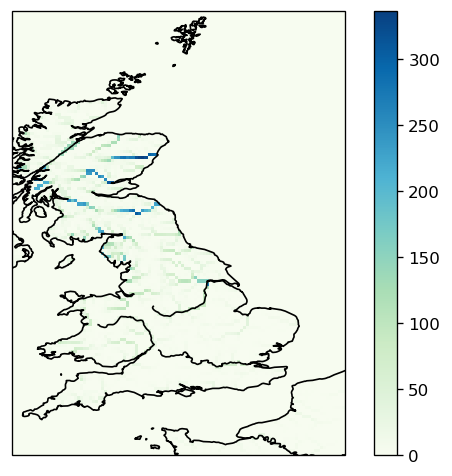

In [18]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111, projection=crs.PlateCarree())
da.plot(ax=ax, cmap="GnBu")

# Overlay ocean and coastines
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS, color="k")
ax.coastlines()

# Add some verification points
#target_longitudes = [7.8, 10.2, 11]
#target_latitudes = [50.3, 49.8, 47]
#ax.scatter(target_longitudes, target_latitudes, s=250, c="r", marker="x", lw=2)

We can get (or set) the values at custom points as well:

<Axes: xlabel='time'>

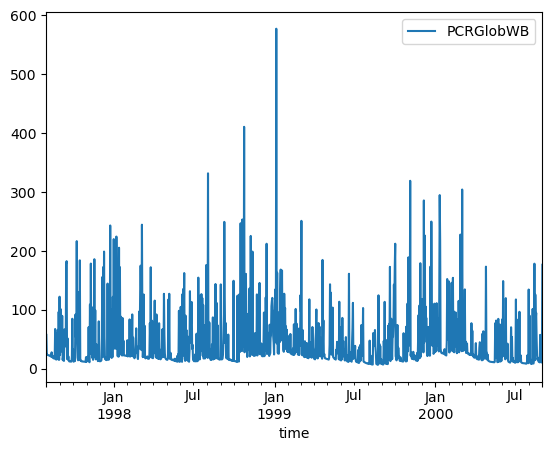

In [19]:

timeseries.plot()

In [20]:
#pcrglob.get_value_at_coords("discharge", lon=target_longitudes, lat=target_latitudes)

## Cleaning up

Models usually perform some "wrap up tasks" at the end of a model run, such as writing the last outputs to disk and releasing memory. In the case of eWaterCycle, another important teardown task is destroying the container in which the model was running. This can free up a lot of resources on your system. Therefore it is good practice to always call `finalize()` when you're done with an experiment.

In [21]:
pcrglob.finalize()